원본 커널 : https://www.kaggle.com/youhanlee/3250feats-532-feats-using-shap-lb-0-436

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2.2)
plt.style.use('seaborn')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
import itertools

import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier


import shap
from tqdm import tqdm
import featuretools as ft

import warnings 
warnings.filterwarnings('ignore')
import time

In [2]:
path = 'C:/Users/user/Desktop/kaggle_data/04. costa-rican-household-poverty-prediction/'

<br>

### 1. Check datasets
#### 1.1 Read dataset

In [3]:
df_train = pd.read_csv(path+'train.csv')
df_test = pd.read_csv(path+'test.csv')

In [4]:
print('df_train shape:', df_train.shape, '  ', 'df_test shape: ', df_test.shape)

df_train shape: (9557, 143)    df_test shape:  (23856, 142)


In [5]:
df_train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [6]:
df_test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [7]:
df_train.columns=='adult'

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [8]:
for i in df_test.columns:
    print(i)

Id
v2a1
hacdor
rooms
hacapo
v14a
refrig
v18q
v18q1
r4h1
r4h2
r4h3
r4m1
r4m2
r4m3
r4t1
r4t2
r4t3
tamhog
tamviv
escolari
rez_esc
hhsize
paredblolad
paredzocalo
paredpreb
pareddes
paredmad
paredzinc
paredfibras
paredother
pisomoscer
pisocemento
pisoother
pisonatur
pisonotiene
pisomadera
techozinc
techoentrepiso
techocane
techootro
cielorazo
abastaguadentro
abastaguafuera
abastaguano
public
planpri
noelec
coopele
sanitario1
sanitario2
sanitario3
sanitario5
sanitario6
energcocinar1
energcocinar2
energcocinar3
energcocinar4
elimbasu1
elimbasu2
elimbasu3
elimbasu4
elimbasu5
elimbasu6
epared1
epared2
epared3
etecho1
etecho2
etecho3
eviv1
eviv2
eviv3
dis
male
female
estadocivil1
estadocivil2
estadocivil3
estadocivil4
estadocivil5
estadocivil6
estadocivil7
parentesco1
parentesco2
parentesco3
parentesco4
parentesco5
parentesco6
parentesco7
parentesco8
parentesco9
parentesco10
parentesco11
parentesco12
idhogar
hogar_nin
hogar_adul
hogar_mayor
hogar_total
dependency
edjefe
edjefa
meaneduc
instlevel

<br>

#### 1.2 Make description df


<br>

#### 1.3 Check Null data

In [9]:
total = df_train.isnull().sum().sort_values(ascending = False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending = False)
missing_df = pd.concat([total, percent], axis =1, keys = ['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
rez_esc,7928,82.954902
v18q1,7342,76.823271
v2a1,6860,71.779847
meaneduc,5,0.052318
SQBmeaned,5,0.052318
techozinc,0,0.000000
techoentrepiso,0,0.000000
techocane,0,0.000000
techootro,0,0.000000
cielorazo,0,0.000000


<br>

#### 1.4 Fill Missing values
- edjefe : 남자 교육 기간
- edjefa : 여자 교육 기간

In [10]:
df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "edjefa"] = df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]
df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "edjefe"] = df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]

df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "edjefa"] = df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]
df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "edjefe"] = df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]

# this field is supposed to be interaction between gender and escolari, but it isn't clear what "yes" means, let's fill it with 4
df_train.loc[df_train['edjefa'] == "yes", "edjefa"] = 4
df_train.loc[df_train['edjefe'] == "yes", "edjefe"] = 4

In [11]:
df_test.loc[df_test['edjefa'] == "yes", "edjefa"] = 4
df_test.loc[df_test['edjefe'] == "yes", "edjefe"] = 4

# create feature with max education of either head of household
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

# fix some inconsistencies in the data - some rows indicate both that the household does and does not have a toilet, 
# if there is no water we'll assume they do not
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "v14a"] = 0
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "sanitario1"] = 0

df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "v14a"] = 0
df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "sanitario1"] = 0

<br>

**reaz_esz, SQBmeaned**
- `rez_esc` : years behind in school-> filled with 0
- `SQBmeaned` : square of the mean years of education of adults in the household ages, Age squared - > same with rez_esc -> filled with 0

In [12]:
df_train['rez_esc'].fillna(0, inplace = True)
df_test['rez_esc'].fillna(0, inplace = True)

In [13]:
df_train['SQBmeaned'].fillna(0, inplace = True)
df_test['SQBmeaned'].fillna(0, inplace = True)


<br>

**meaneduc**

- meaneduc : avearge years of education for adults

In [14]:
df_train['meaneduc'].fillna(0, inplace = True)
df_test['meaneduc'].fillna(0, inplace = True)

<br>

**v18q1**

- number of tablets household own

In [15]:
df_train.v18q.value_counts()

0    7342
1    2215
Name: v18q, dtype: int64

In [16]:
df_train.loc[df_train['v18q'] == 1, 'v18q1'].value_counts()

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

In [17]:
df_train.loc[df_train['v18q1'] == 0, 'v18q1'].value_counts()

Series([], Name: v18q1, dtype: int64)

In [18]:
df_train['v18q1'].fillna(0, inplace = True)
df_test['v18q1'].fillna(0, inplace = True)


<br>

**tipovivi3**

- rent or not

In [19]:
df_train['tipovivi3'].value_counts()

0    7821
1    1736
Name: tipovivi3, dtype: int64

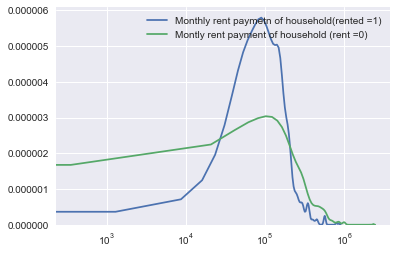

In [20]:
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 1, 'v2a1'], label = 'Monthly rent paymetn of household(rented =1)')
sns.kdeplot(df_train.loc[df_train['tipovivi3'] ==0, 'v2a1'], label = 'Montly rent payment of household (rent =0)')

plt.xscale('log')
plt.show()

In [21]:
df_train['v2a1'].fillna(0, inplace = True)
df_test['v2a1'].fillna(0, inplace = True)

In [22]:
total = df_train.isnull().sum().sort_values(ascending = False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending = False)

missing_df = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,9557,100.0
Target,0,0.0
sanitario3,0,0.0
sanitario2,0,0.0
sanitario1,0,0.0
coopele,0,0.0
noelec,0,0.0
planpri,0,0.0
public,0,0.0
abastaguano,0,0.0


In [23]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_test.isnull().sum() / df_test.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,23856,100.0
abastaguano,0,0.0
sanitario2,0,0.0
sanitario1,0,0.0
coopele,0,0.0
noelec,0,0.0
planpri,0,0.0
public,0,0.0
abastaguafuera,0,0.0
sanitario5,0,0.0


<br>

### 2. Feature Engineering

#### 2.1 Object features

In [24]:
features_object = [col for col in df_train.columns if df_train[col].dtype == 'object']

In [25]:
features_object = []
for col in df_train.select_dtypes('object'):
    features_object.append(col)

In [26]:
features_object

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']

<br>

**dependency**

In [27]:
df_train['dependency'] = np.sqrt(df_train['SQBdependency'])
df_test['dependency'] = np.sqrt(df_test['SQBdependency'])

<br>

**edjefe**

In [28]:
def replace_edjefe(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x
    
df_train['edjefe'] = df_train['edjefe'].apply(replace_edjefe).astype(float)
df_test['edjefe'] = df_test['edjefe'].apply(replace_edjefe).astype(float)

<br>

**edjefa**

In [29]:
def replace_edjefa(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x
    
df_train['edjefa'] = df_train['edjefa'].apply(replace_edjefa).astype(float)
df_test['edjefa'] = df_test['edjefa'].apply(replace_edjefa).astype(float)

In [30]:
df_train['edjef'] = np.max(df_train[['edjefa', 'edjefe']], axis = 1)
df_test['edjef'] = np.max(df_test[['edjefa', 'edjefe']], axis = 1)


<br>

**roof and electricity**

In [31]:
df_train['roof_waste_material'] = np.nan
df_test['roof_waste_material'] = np.nan
df_train['electricity_other'] = np.nan
df_test['electricity_other'] = np.nan

In [32]:
def fill_roof_exception(x):
    if (x['techozinc'] ==0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0):
        return 1
    else:
        return 0
def fill_no_electricity(x):
    if (x['public'] ==0) and(x['planpri'] ==0) and (x['noelec'] ==0) and(x['coopele'] ==0):
        return 1
    else:
        return 0
    

In [33]:
df_train['roof_waste_material'] = df_train.apply(lambda x : fill_roof_exception(x), axis =1)
df_test['roof_waste_material'] = df_test.apply(lambda x : fill_roof_exception(x), axis =1)

df_train['electricity_other'] = df_train.apply(lambda x : fill_no_electricity(x), axis =1)
df_test['electricity_other'] = df_test.apply(lambda x : fill_no_electricity(x), axis = 1)

<br>

### 2.2 Extract cat features

In [34]:
binary_cat_features = [col for col in df_train.columns if df_train[col].value_counts().shape[0] == 2]

<br>

### 2.3 Make new features using continuous feature

In [35]:
continuous_features = [col for col in df_train.columns if col not in binary_cat_features]
continuous_features = [col for col in continuous_features if col not in features_object]
continuous_features = [col for col in continuous_features if col not in ['Id', 'Target', 'idhogar']]

In [36]:
print('There are {} continuous features'.format(len(continuous_features)))

There are 37 continuous features


In [37]:
df_train['edjef'].value_counts()

6.0     2792
11.0    1150
9.0      723
8.0      474
15.0     473
3.0      459
0.0      435
7.0      413
4.0      400
5.0      398
14.0     328
17.0     278
2.0      278
16.0     247
10.0     207
12.0     185
13.0     155
1.0       65
21.0      48
18.0      22
19.0      18
20.0       9
Name: edjef, dtype: int64

<br>

- `hhsize` 와 `tamhog` 이 똑같은 의미라고 판단해, tamhog 지움

In [38]:
df_train.drop('tamhog', axis = 1, inplace = True)
df_test.drop('tamhog', axis = 1, inplace = True)

<br>

#### Family features
- hogar_nin, hogar_adul, hogar_mayor, hogar_total, r4h1, r4h2, r4h3, r4m1, r4m2, r4m3, r4t1, r4t2, r4t3, tmbhog, tamvid, rez_esc, escolari

**Family size features (substract, ratio)**

In [39]:
df_train['adult'] = df_train['hogar_adul'] - df_train['hogar_mayor']

df_train['dependency_count'] = df_train['hogar_nin'] + df_train['hogar_mayor']

df_train['dependency'] = df_train['dependency_count'] / df_train['adult']

df_train['child_percent'] = df_train['hogar_nin'] / df_train['hogar_total']

df_train['elder_percent'] = df_train['hogar_mayor'] / df_train['hogar_total']

df_train['adult_percent'] = df_train['hogar_adul'] / df_train['hogar_total']

df_train['males_younger_12_years_percent'] = df_train['r4h1'] / df_train['hogar_total']

df_train['males_older_12_years_percent'] = df_train['r4h2'] / df_train['hogar_total']

df_train['males_percent'] = df_train['r4h3'] / df_train['hogar_total']

df_train['females_younger_12_years_percent'] = df_train['r4m1'] / df_train['hogar_total']

df_train['females_older_12_years_percent'] = df_train['r4m2'] / df_train['hogar_total']

df_train['females_percent'] = df_train['r4m3'] / df_train['hogar_total']

df_train['persons_younger_12_years_percent'] = df_train['r4t1'] / df_train['hogar_total']

df_train['persons_older_12_years_percent'] = df_train['r4t2'] / df_train['hogar_total']

df_train['persons_percent'] = df_train['r4t3'] / df_train['hogar_total']

In [40]:
df_test['adult'] = df_test['hogar_adul'] - df_test['hogar_mayor']

df_test['dependency_count'] = df_test['hogar_nin'] + df_test['hogar_mayor']

df_test['dependency'] = df_test['dependency_count'] / df_test['adult']

df_test['child_percent'] = df_test['hogar_nin'] / df_test['hogar_total']

df_test['elder_percent'] = df_test['hogar_mayor'] / df_test['hogar_total']

df_test['adult_percent'] = df_test['hogar_adul'] / df_test['hogar_total']

df_test['males_younger_12_years_percent'] = df_test['r4h1'] / df_test['hogar_total']

df_test['males_older_12_years_percent'] = df_test['r4h2'] / df_test['hogar_total']

df_test['males_percent'] = df_test['r4h3'] / df_test['hogar_total']

df_test['females_younger_12_years_percent'] = df_test['r4m1'] / df_test['hogar_total']

df_test['females_older_12_years_percent'] = df_test['r4m2'] / df_test['hogar_total']

df_test['females_percent'] = df_test['r4m3'] / df_test['hogar_total']

df_test['persons_younger_12_years_percent'] = df_test['r4t1'] / df_test['hogar_total']

df_test['persons_older_12_years_percent'] = df_test['r4t2'] / df_test['hogar_total']

df_test['persons_percent'] = df_test['r4t3'] / df_test['hogar_total']

In [41]:
df_train['males_younger_12_years_in_household_size'] = df_train['r4h1'] / df_train['hhsize']
df_train['males_older_12_years_in_household_size'] = df_train['r4h2'] / df_train['hhsize']
df_train['males_in_household_size'] = df_train['r4h3'] / df_train['hhsize']
df_train['females_younger_12_years_in_household_size'] = df_train['r4m1'] / df_train['hhsize']
df_train['females_older_12_years_in_household_size'] = df_train['r4m2'] / df_train['hhsize']
df_train['females_in_household_size'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_in_household_size'] = df_train['r4t1'] / df_train['hhsize']
df_train['persons_older_12_years_in_household_size'] = df_train['r4t2'] / df_train['hhsize']
df_train['persons_in_household_size'] = df_train['r4t3'] / df_train['hhsize']

In [42]:
df_test['males_younger_12_years_in_household_size'] = df_test['r4h1'] / df_test['hhsize']
df_test['males_older_12_years_in_household_size'] = df_test['r4h2'] / df_test['hhsize']
df_test['males_in_household_size'] = df_test['r4h3'] / df_test['hhsize']
df_test['females_younger_12_years_in_household_size'] = df_test['r4m1'] / df_test['hhsize']
df_test['females_older_12_years_in_household_size'] = df_test['r4m2'] / df_test['hhsize']
df_test['females_in_household_size'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_in_household_size'] = df_test['r4t1'] / df_test['hhsize']
df_test['persons_older_12_years_in_household_size'] = df_test['r4t2'] / df_test['hhsize']
df_test['persons_in_household_size'] = df_test['r4t3'] / df_test['hhsize']

In [43]:
df_train['overcrowding_room_and_bedroom'] = (df_train['hacdor'] + df_train['hacapo'])/2
df_test['overcrowding_room_and_bedroom'] = (df_test['hacdor'] + df_test['hacapo'])/2

In [44]:
df_train['escolari_age'] = df_train['escolari']/df_train['age']
df_test['escolari_age'] = df_test['escolari']/df_test['age']

df_train['age_12_19'] = df_train['hogar_nin'] - df_train['r4t1']
df_test['age_12_19'] = df_test['hogar_nin'] - df_test['r4t1'] 

In [45]:
df_train['phones-per-capita'] = df_train['qmobilephone'] / df_train['tamviv']
df_train['tablets-per-capita'] = df_train['v18q1'] / df_train['tamviv']
df_train['rooms-per-capita'] = df_train['rooms'] / df_train['tamviv']
df_train['rent-per-capita'] = df_train['v2a1'] / df_train['tamviv']

In [46]:
df_test['phones-per-capita'] = df_test['qmobilephone'] / df_test['tamviv']
df_test['tablets-per-capita'] = df_test['v18q1'] / df_test['tamviv']
df_test['rooms-per-capita'] = df_test['rooms'] / df_test['tamviv']
df_test['rent-per-capita'] = df_test['v2a1'] / df_test['tamviv']

In [47]:
(df_train['hogar_total'] == df_train['r4t3']).sum()

9509

<br>

#### Rent per family features

In [48]:
family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
new_feats = []

for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v2a1', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v2a1'] / df_train[col]
    df_test[new_col_name] = df_test['v2a1'] / df_test[col]

In [49]:
new_feats

['new_v2a1_per_adult',
 'new_v2a1_per_hogar_adul',
 'new_v2a1_per_hogar_mayor',
 'new_v2a1_per_hogar_nin',
 'new_v2a1_per_hogar_total',
 'new_v2a1_per_r4h1',
 'new_v2a1_per_r4h2',
 'new_v2a1_per_r4h3',
 'new_v2a1_per_r4m1',
 'new_v2a1_per_r4m2',
 'new_v2a1_per_r4m3',
 'new_v2a1_per_r4t1',
 'new_v2a1_per_r4t2',
 'new_v2a1_per_r4t3',
 'new_v2a1_per_hhsize']

In [50]:
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace = True)
    df_train[col].fillna(0, inplace = True)
    
    df_test[col].replace([np.inf], np.nan, inplace = True)
    df_test[col].fillna(0, inplace = True)

<br>

#### Room per familly features

In [51]:
new_feats = []

for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rooms'] / df_train[col]
    df_test[new_col_name] = df_test['rooms'] / df_test[col]
    
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace = True)
    df_train[col].fillna(0, inplace = True)
    
    df_test[col].replace([np.inf], np.nan, inplace = True)
    df_test[col].fillna(0, inplace = True)

<br>

#### Bedroom Per family features

In [52]:
new_feats = []

for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('bedrooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['bedrooms'] / df_train[col]
    df_test[new_col_name] = df_test['bedrooms'] / df_test[col]
    
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace = True)
    df_train[col].fillna(0, inplace = True)
    
    df_test[col].replace([np.inf], np.nan, inplace = True)
    df_test[col].fillna(0, inplace = True)
    

In [53]:
print(df_train.shape, df_test.shape)

(9557, 220) (23856, 219)


<br>

#### Tabulet per family features

In [54]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v18q1', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v18q1'] / df_train[col]
    df_test[new_col_name] = df_test['v18q1'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

<br>

#### phone per family features

In [55]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('qmobilephone', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['qmobilephone'] / df_train[col]
    df_test[new_col_name] = df_test['qmobilephone'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

<br>

#### rez_esc(Years behind in school) per family features

In [56]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rez_esc', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rez_esc'] / df_train[col]
    df_test[new_col_name] = df_test['rez_esc'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [57]:
df_train['rez_esc_age'] = df_train['rez_esc'] / df_train['age']
df_train['rez_esc_escolari'] = df_train['rez_esc'] / df_train['escolari']

df_test['rez_esc_age'] = df_test['rez_esc'] / df_test['age']
df_test['rez_esc_escolari'] = df_test['rez_esc'] / df_test['escolari']

<br>

#### Rich features

In [58]:
df_train['tabulet_x_qmobilephone'] = df_train['v18q1'] * df_train['qmobilephone']
df_test['tabulet_x_qmobilephone'] = df_test['v18q1'] * df_test['qmobilephone']

In [59]:
# wall, roof, floor - > 이진 변수인데, 각각의 특성 내 값을 곱하면서 새로운 특성을 만들수 있음
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
# wall and floor
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

# roof and floor
for col1 in ['etecho1', 'etecho2', 'etecho3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [60]:
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        for col3 in ['eviv1', 'eviv2', 'eviv3']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [61]:
print(df_train.shape, df_test.shape)

(9557, 322) (23856, 321)


<br>

#### electirictiy 와 energy features -- energy features

In [62]:
for col1 in ['public', 'planpri', 'noelec', 'coopele']:
    for col2 in ['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

<br>

#### toilet 과 rubbish disposal features 합치기 - other_infra features

In [63]:
for col1 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
    for col2 in ['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

<br>

#### toilet and water provision features -- water features

In [64]:
for col1 in ['abastaguadentro', 'abastaguafuera', 'abastaguano']:
    for col2 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [65]:
print(df_train.shape, df_test.shape)

(9557, 383) (23856, 382)


<br>

#### education + area = education_Zone_features

In [66]:
for col1 in ['area1', 'area2']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

<br>

#### Mix region and Education

In [67]:
for col1 in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

<br>

#### Multiply television / mobilephone / computer / tabulet / refrigerator -> electornics features

In [68]:
df_train['electronics'] = df_train['computer'] * df_train['mobilephone'] * df_train['television'] * df_train['v18q'] * df_train['refrig']
df_test['electronics'] = df_test['computer'] * df_test['mobilephone'] * df_test['television'] * df_test['v18q'] * df_test['refrig']

df_train['no_appliances'] = df_train['refrig'] + df_train['computer'] + df_train['television'] + df_train['mobilephone']
df_test['no_appliances'] = df_test['refrig'] + df_test['computer'] + df_test['television'] + df_test['mobilephone']

<br>

#### Mix wall material of roof, floor, wall

In [69]:
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

for col1 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
    for col1 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]        
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        for col3 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [70]:
print(df_train.shape, df_test.shape)

(9557, 733) (23856, 732)


<br>

#### Remove feature with only one value

In [71]:
cols_with_only_one_value = []

for col in df_train.columns:
    if col == 'Target':
        continue
    if df_train[col].value_counts().shape[0] == 1 or df_test[col].value_counts().shape[0] == 1:
        print(col)
        cols_with_only_one_value.append(col)

elimbasu5
new_planpri_x_energcocinar1
new_planpri_x_energcocinar2
new_planpri_x_energcocinar3
new_planpri_x_energcocinar4
new_noelec_x_energcocinar2
new_sanitario1_x_elimbasu4
new_sanitario1_x_elimbasu5
new_sanitario1_x_elimbasu6
new_sanitario2_x_elimbasu4
new_sanitario2_x_elimbasu5
new_sanitario2_x_elimbasu6
new_sanitario3_x_elimbasu5
new_sanitario5_x_elimbasu4
new_sanitario5_x_elimbasu5
new_sanitario5_x_elimbasu6
new_sanitario6_x_elimbasu2
new_sanitario6_x_elimbasu4
new_sanitario6_x_elimbasu5
new_sanitario6_x_elimbasu6
new_abastaguafuera_x_sanitario6
new_abastaguano_x_sanitario2
new_abastaguano_x_sanitario6
new_paredblolad_x_pisonatur
new_paredblolad_x_pisonotiene
new_paredzocalo_x_pisoother
new_paredzocalo_x_pisonatur
new_paredpreb_x_pisonatur
new_pareddes_x_pisoother
new_pareddes_x_pisonatur
new_paredmad_x_pisoother
new_paredmad_x_pisonatur
new_paredzinc_x_pisoother
new_paredzinc_x_pisonatur
new_paredfibras_x_pisoother
new_paredfibras_x_pisonatur
new_paredfibras_x_pisonotiene
new_p

In [72]:
df_train.drop(cols_with_only_one_value, axis = 1, inplace = True)
df_test.drop(cols_with_only_one_value, axis = 1, inplace = True)

In [73]:
df_train['v2a1'].value_counts().shape

(157,)

<br>

#### Check whether both train and test have same features

In [74]:
cols_train = np.array(sorted([col for col in df_train.columns if col != 'Target']))

cols_test = np.array(sorted(df_test.columns))

In [75]:
(cols_train == cols_test).sum() == len(cols_train)


True

<br>

### 2.4 aggregation features


#### Aggregation for family features

In [76]:
def max_min(x):
    return x.max() - x.min()

In [77]:
agg_train = pd.DataFrame()
agg_test = pd.DataFrame()

for item in tqdm(family_size_features):
    for i, function in enumerate(['mean', 'std', 'min', 'max', 'sum', 'count', max_min]):
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new_' + 'max_min'
        else:
            new_col = item + '_new_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test
        
print('new aggregate train set has {} rows and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggreagte test set has {} rows and {} features'.format(agg_test.shape[0], agg_test.shape[1]))




100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:18<00:00,  1.25s/it]

new aggregate train set has 2988 rows and 105 features
new aggreagte test set has 7352 rows and 105 features


In [78]:
for item in tqdm(family_size_features):
    print(item)

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15051.33it/s]

adult
hogar_adul
hogar_mayor
hogar_nin
hogar_total
r4h1
r4h2
r4h3
r4m1
r4m2
r4m3
r4t1
r4t2
r4t3
hhsize


In [79]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']



for item in tqdm(aggr_list):
    for function in ['count', 'sum']:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        new_col = item + '_new1_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test
print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 44.84it/s]

new aggregate train set has 2988 rows, and 199 features
new aggregate test set has 7352 rows, and 199 features


In [80]:
aggr_list = ['escolari', 'age', 'escolari_age', 'dependency', 'bedrooms', 'overcrowding', 'rooms', 'qmobilephone', 'v18q1']

for item in tqdm(aggr_list):
    for function in ['mean','std','min','max','sum', 'count', max_min]:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new2_' + 'max_min'
        else:
            new_col = item + '_new2_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test

print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.32s/it]

new aggregate train set has 2988 rows, and 208 features
new aggregate test set has 7352 rows, and 208 features


In [81]:
agg_test = agg_test.reset_index()
agg_train = agg_train.reset_index()

train_agg = pd.merge(df_train, agg_train, on = 'idhogar')
test = pd.merge(df_test, agg_test, on = 'idhogar')

train_agg.fillna(value = 0, inplace = True)
test.fillna(value = 0, inplace = True)

print('train shape: ', train_agg.shape, 'test shape: ', test.shape)

train shape:  (9557, 724) test shape:  (23856, 723)


In [82]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 1006) test shape: (23856, 1005)


In [83]:
cols_nums = ['age', 'meaneduc', 'dependency', 
             'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
             'bedrooms', 'overcrowding']

for function in tqdm(['mean','std','min','max','sum', 'count', max_min]):
    for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
        group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_train.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_train][2:]

        group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_test.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_test][2:]

        train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
        test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
        
print('train shape:', train_agg.shape, 'test shape:', test.shape)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:51<00:00, 50.28s/it]

train shape: (9557, 2980) test shape: (23856, 2979)


In [84]:
train = train_agg.query('parentesco1==1')

In [85]:
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,new5_lugar6_idhogar_eviv1_<function max_min at 0x000002DA69EE12F0>,new5_lugar6_idhogar_eviv2_<function max_min at 0x000002DA69EE12F0>,new5_lugar6_idhogar_eviv3_<function max_min at 0x000002DA69EE12F0>,new5_lugar6_idhogar_refrig_<function max_min at 0x000002DA69EE12F0>,new5_lugar6_idhogar_television_<function max_min at 0x000002DA69EE12F0>,new5_lugar6_idhogar_mobilephone_<function max_min at 0x000002DA69EE12F0>,new5_lugar6_idhogar_area1_<function max_min at 0x000002DA69EE12F0>,new5_lugar6_idhogar_area2_<function max_min at 0x000002DA69EE12F0>,new5_lugar6_idhogar_v18q_<function max_min at 0x000002DA69EE12F0>,new5_lugar6_idhogar_edjef_<function max_min at 0x000002DA69EE12F0>
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0.0
5,ID_ec05b1a7b,180000.0,0,5,0,1,1,1,1.0,0,...,0,0,0,0,0,0,0,0,0,0.0
8,ID_1284f8aad,130000.0,1,2,0,1,1,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [86]:
train['dependency'].replace(np.inf, 0 , inplace = True)
test['dependency'].replace(np.inf, 0, inplace = True)

In [87]:
submission = test[['Id']]

#Remove useless feature to reduce dimension
train.drop(columns=['idhogar','Id', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)
test.drop(columns=['idhogar','Id',  'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

correlation = train.corr()
correlation = correlation['Target'].sort_values(ascending=False)

In [88]:
print('final_data size', train.shape, test.shape)

final_data size (2973, 2968) (23856, 2967)


In [89]:
print(f'The most 20 positive feature: \n{correlation.head(40)}')

The most 20 positive feature: 
Target                                1.000000
new5_lugar3_idhogar_edjef_max         0.334254
new5_lugar5_idhogar_edjef_max         0.334254
new5_lugar2_idhogar_edjef_max         0.334254
new5_lugar1_idhogar_edjef_max         0.334254
new5_lugar4_idhogar_edjef_max         0.334254
new5_lugar6_idhogar_edjef_max         0.334254
new5_lugar3_idhogar_edjef_mean        0.333873
new5_lugar1_idhogar_edjef_mean        0.333873
new5_lugar6_idhogar_edjef_mean        0.333873
new5_lugar2_idhogar_edjef_mean        0.333873
new5_lugar4_idhogar_edjef_mean        0.333873
new5_lugar5_idhogar_edjef_mean        0.333873
escolari                              0.333791
new5_lugar1_idhogar_edjef_min         0.333791
new5_lugar5_idhogar_edjef_min         0.333791
new5_lugar2_idhogar_edjef_min         0.333791
new5_lugar4_idhogar_edjef_min         0.333791
new5_lugar6_idhogar_edjef_min         0.333791
new5_lugar3_idhogar_edjef_min         0.333791
edjef                        

In [90]:
print(f'The most 20 negative feature: \n{correlation.dropna().tail(20)}')

The most 20 negative feature: 
new5_lugar3_idhogar_instlevel1_sum   -0.271204
new3_lugar4_idhogar_instlevel1       -0.271204
new5_lugar2_idhogar_instlevel1_sum   -0.271204
new5_lugar6_idhogar_instlevel1_sum   -0.271204
new3_lugar1_idhogar_instlevel1       -0.271204
dependency_count                     -0.283908
new5_lugar6_idhogar_instlevel2_sum   -0.297868
new3_lugar6_idhogar_instlevel2       -0.297868
new5_lugar5_idhogar_instlevel2_sum   -0.297868
instlevel2_new1_sum                  -0.297868
new5_lugar4_idhogar_instlevel2_sum   -0.297868
new3_lugar1_idhogar_instlevel2       -0.297868
new5_lugar3_idhogar_instlevel2_sum   -0.297868
new3_lugar2_idhogar_instlevel2       -0.297868
new5_lugar2_idhogar_instlevel2_sum   -0.297868
new3_lugar4_idhogar_instlevel2       -0.297868
new5_lugar1_idhogar_instlevel2_sum   -0.297868
new3_lugar3_idhogar_instlevel2       -0.297868
new3_lugar5_idhogar_instlevel2       -0.297868
dependency                           -0.304563
Name: Target, dtype: float64


<br>

### 4. Feature selection using shap

In [91]:
binary_cat_features = [col for col in train.columns if train[col].value_counts().shape[0] == 2]

object_features = ['edjefe', 'edjefa']

categorical_feats = binary_cat_features + object_features

In [92]:
def evaluate_macroF1_lgb(truth, predictions):
    pred_labels = predictions.reshape(len(np.unique(truth)), -1).argmax(axis = 0)
    f1 = f1_score(truth, pred_labels, average = 'macro')
    return ('macroF1', f1, True)

In [93]:
y = train['Target']
train.drop(columns = ['Target'], inplace = True)

In [94]:
def print_execution_time(start):
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("*"*20, 'Execution ended in {:0>2}h {:0>2}hm {:05.2f}s'.format(int(hours), int(minutes), seconds), "*"*20)

In [95]:
def extract_good_features_using_shap_LGB(params, SEED):
    clf = lgb.LGBMClassifier(objective='multiclass',
                             random_state=1989,
                             max_depth=params['max_depth'], 
                             learning_rate=params['learning_rate'],  
                             silent=True, 
                             metric='multi_logloss',
                             n_jobs=-1, n_estimators=10000, 
                             class_weight='balanced',
                             colsample_bytree = params['colsample_bytree'], 
                             min_split_gain= params['min_split_gain'], 
                             bagging_freq = params['bagging_freq'],
                             min_child_weight=params['min_child_weight'],
                             num_leaves = params['num_leaves'], 
                             subsample = params['subsample'],
                             reg_alpha= params['reg_alpha'],
                             reg_lambda= params['reg_lambda'],
                             num_class=len(np.unique(y)),
                             bagging_seed=SEED,
                             seed=SEED,
                            )

    kfold = 5
    kf = StratifiedKFold(n_splits=kfold, shuffle=True)
    feat_importance_df  = pd.DataFrame()

    
    for i, (train_index, test_index) in enumerate(kf.split(train, y)):
        print('='*30, '{} of {} folds'.format(i+1, kfold), '='*30)
        start = time.time()
        X_train, X_val = train.iloc[train_index], train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric=evaluate_macroF1_lgb, categorical_feature=categorical_feats,
                early_stopping_rounds=500, verbose=500)
        shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
        fold_importance_df  = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns
        fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(1).mean(0))
        fold_importance_df['feat_imp'] = clf.feature_importances_
        feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])
        print_execution_time(start)

    feat_importance_df_shap = feat_importance_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()

    return feat_importance_df_shap

In [96]:
total_shap_df  = pd.DataFrame()
NUM_ITERATIONS = 50
for SEED in range(NUM_ITERATIONS):
    print('#'*40, '{} of {} iterations'.format(SEED+1, NUM_ITERATIONS), '#' * 40)
    params = {'max_depth': np.random.choice([5, 6, 7, 8, 10, 12, -1]),
             'learning_rate': np.random.rand() * 0.02,
              'colsample_bytree': np.random.rand() * (1 - 0.5) + 0.5,
              'subsample': np.random.rand() * (1 - 0.5) + 0.5,
              'min_split_gain': np.random.rand() * 0.2,
              'num_leaves': np.random.choice([32, 48, 64]),
              'reg_alpha': np.random.rand() * 2,
              'reg_lambda': np.random.rand() *2,
              'bagging_freq': np.random.randint(4) +1,
              'min_child_weight': np.random.randint(100) + 20
             }
    temp_shap_df = extract_good_features_using_shap_LGB(params, SEED)
    total_shap_df = pd.concat([total_shap_df, temp_shap_df])

######################################## 1 of 50 iterations ########################################
============================== 1 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.07899	training's macroF1: 0.503939	valid_1's multi_logloss: 1.0645	valid_1's macroF1: 0.382898
[1000]	training's multi_logloss: 0.994047	training's macroF1: 0.544153	valid_1's multi_logloss: 1.04278	valid_1's macroF1: 0.396418
[1500]	training's multi_logloss: 0.937831	training's macroF1: 0.58102	valid_1's multi_logloss: 1.03557	valid_1's macroF1: 0.393298
[2000]	training's multi_logloss: 0.894624	training's macroF1: 0.610233	valid_1's multi_logloss: 1.03424	valid_1's macroF1: 0.407753
Early stopping, best iteration is:
[1833]	training's multi_logloss: 0.908185	training's macroF1: 0.600549	valid_1's multi_logloss: 1.03479	valid_1's macroF1: 0.408648
******************** Execution ended in 00h 01hm 00.73s ***************

******************** Execution ended in 00h 01hm 00.76s ********************
============================== 5 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 0.947881	training's macroF1: 0.623347	valid_1's multi_logloss: 1.01718	valid_1's macroF1: 0.417192
[1000]	training's multi_logloss: 0.78962	training's macroF1: 0.703344	valid_1's multi_logloss: 0.977984	valid_1's macroF1: 0.430026
Early stopping, best iteration is:
[830]	training's multi_logloss: 0.833869	training's macroF1: 0.684499	valid_1's multi_logloss: 0.985401	valid_1's macroF1: 0.443014
******************** Execution ended in 00h 00hm 58.95s ********************
######################################## 4 of 50 iterations ########################################
============================== 1 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.00208	t

******************** Execution ended in 00h 00hm 48.84s ********************
============================== 3 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 0.800842	training's macroF1: 0.689163	valid_1's multi_logloss: 1.02861	valid_1's macroF1: 0.401077
[1000]	training's multi_logloss: 0.623874	training's macroF1: 0.764185	valid_1's multi_logloss: 1.00953	valid_1's macroF1: 0.412829
[1500]	training's multi_logloss: 0.52281	training's macroF1: 0.808325	valid_1's multi_logloss: 0.999553	valid_1's macroF1: 0.41717
Early stopping, best iteration is:
[1236]	training's multi_logloss: 0.570359	training's macroF1: 0.789664	valid_1's multi_logloss: 1.00318	valid_1's macroF1: 0.425171
******************** Execution ended in 00h 01hm 00.08s ********************
============================== 4 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	train

Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 0.907874	training's macroF1: 0.625005	valid_1's multi_logloss: 1.03612	valid_1's macroF1: 0.385616
Early stopping, best iteration is:
[4]	training's multi_logloss: 1.3729	training's macroF1: 0.462444	valid_1's multi_logloss: 1.36832	valid_1's macroF1: 0.416813
******************** Execution ended in 00h 00hm 12.48s ********************
============================== 2 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 0.912842	training's macroF1: 0.605659	valid_1's multi_logloss: 1.02744	valid_1's macroF1: 0.404209
[1000]	training's multi_logloss: 0.774382	training's macroF1: 0.675223	valid_1's multi_logloss: 1.01882	valid_1's macroF1: 0.399878
Early stopping, best iteration is:
[581]	training's multi_logloss: 0.88505	training's macroF1: 0.614492	valid_1's multi_logloss: 1.0248	valid_1's macroF1: 0.417713
****

Early stopping, best iteration is:
[232]	training's multi_logloss: 0.970511	training's macroF1: 0.58513	valid_1's multi_logloss: 1.06089	valid_1's macroF1: 0.415134
******************** Execution ended in 00h 00hm 20.28s ********************
######################################## 12 of 50 iterations ########################################
============================== 1 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 0.923806	training's macroF1: 0.595159	valid_1's multi_logloss: 1.00721	valid_1's macroF1: 0.448697
[1000]	training's multi_logloss: 0.797576	training's macroF1: 0.664625	valid_1's multi_logloss: 0.992576	valid_1's macroF1: 0.465812
[1500]	training's multi_logloss: 0.717057	training's macroF1: 0.696009	valid_1's multi_logloss: 0.986978	valid_1's macroF1: 0.472141
Early stopping, best iteration is:
[1315]	training's multi_logloss: 0.743759	training's macroF1: 0.685862	valid_1's multi_

[500]	training's multi_logloss: 1.10865	training's macroF1: 0.499004	valid_1's multi_logloss: 1.08392	valid_1's macroF1: 0.406218
[1000]	training's multi_logloss: 1.01796	training's macroF1: 0.538029	valid_1's multi_logloss: 1.04775	valid_1's macroF1: 0.423082
[1500]	training's multi_logloss: 0.960283	training's macroF1: 0.560474	valid_1's multi_logloss: 1.03667	valid_1's macroF1: 0.444909
Early stopping, best iteration is:
[1320]	training's multi_logloss: 0.979195	training's macroF1: 0.552282	valid_1's multi_logloss: 1.03984	valid_1's macroF1: 0.451428
******************** Execution ended in 00h 00hm 38.08s ********************
============================== 4 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.10654	training's macroF1: 0.522228	valid_1's multi_logloss: 1.08959	valid_1's macroF1: 0.417716
Early stopping, best iteration is:
[414]	training's multi_logloss: 1.13071	training's macroF1: 0

[500]	training's multi_logloss: 1.1981	training's macroF1: 0.471589	valid_1's multi_logloss: 1.16204	valid_1's macroF1: 0.39048
Early stopping, best iteration is:
[181]	training's multi_logloss: 1.29198	training's macroF1: 0.443058	valid_1's multi_logloss: 1.26183	valid_1's macroF1: 0.40708
******************** Execution ended in 00h 00hm 11.18s ********************
============================== 2 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.20676	training's macroF1: 0.463173	valid_1's multi_logloss: 1.15429	valid_1's macroF1: 0.381695
Early stopping, best iteration is:
[35]	training's multi_logloss: 1.3667	training's macroF1: 0.4232	valid_1's multi_logloss: 1.3573	valid_1's macroF1: 0.40172
******************** Execution ended in 00h 00hm 09.34s ********************
============================== 3 of 5 folds ==============================
Training until validation scores don't improve for 50

******************** Execution ended in 00h 00hm 30.97s ********************
============================== 5 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.10588	training's macroF1: 0.556192	valid_1's multi_logloss: 1.10606	valid_1's macroF1: 0.436142
Early stopping, best iteration is:
[144]	training's multi_logloss: 1.273	training's macroF1: 0.507877	valid_1's multi_logloss: 1.25392	valid_1's macroF1: 0.456981
******************** Execution ended in 00h 00hm 17.87s ********************
######################################## 20 of 50 iterations ########################################
============================== 1 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 0.804207	training's macroF1: 0.688736	valid_1's multi_logloss: 0.986446	valid_1's macroF1: 0.422416
Early stopping, best iteration is:
[25]	train

[500]	training's multi_logloss: 0.999397	training's macroF1: 0.56989	valid_1's multi_logloss: 1.06285	valid_1's macroF1: 0.399761
[1000]	training's multi_logloss: 0.879659	training's macroF1: 0.627427	valid_1's multi_logloss: 1.03838	valid_1's macroF1: 0.425342
[1500]	training's multi_logloss: 0.801894	training's macroF1: 0.671654	valid_1's multi_logloss: 1.02873	valid_1's macroF1: 0.413817
Early stopping, best iteration is:
[1081]	training's multi_logloss: 0.865349	training's macroF1: 0.631619	valid_1's multi_logloss: 1.03593	valid_1's macroF1: 0.429431
******************** Execution ended in 00h 00hm 37.45s ********************
============================== 4 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.00168	training's macroF1: 0.579811	valid_1's multi_logloss: 1.04669	valid_1's macroF1: 0.433418
[1000]	training's multi_logloss: 0.882044	training's macroF1: 0.631593	valid_1's multi_logloss:

Early stopping, best iteration is:
[157]	training's multi_logloss: 0.911763	training's macroF1: 0.681108	valid_1's multi_logloss: 1.03359	valid_1's macroF1: 0.416189
******************** Execution ended in 00h 00hm 21.85s ********************
######################################## 25 of 50 iterations ########################################
============================== 1 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.16815	training's macroF1: 0.616897	valid_1's multi_logloss: 1.17697	valid_1's macroF1: 0.410911
Early stopping, best iteration is:
[6]	training's multi_logloss: 1.38267	training's macroF1: 0.539178	valid_1's multi_logloss: 1.3822	valid_1's macroF1: 0.4179
******************** Execution ended in 00h 00hm 16.71s ********************
============================== 2 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training

Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.32573	training's macroF1: 0.451068	valid_1's multi_logloss: 1.31	valid_1's macroF1: 0.378463
Early stopping, best iteration is:
[184]	training's multi_logloss: 1.36171	training's macroF1: 0.443836	valid_1's multi_logloss: 1.35464	valid_1's macroF1: 0.381564
******************** Execution ended in 00h 00hm 16.77s ********************
============================== 5 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.32545	training's macroF1: 0.448743	valid_1's multi_logloss: 1.30921	valid_1's macroF1: 0.382498
Early stopping, best iteration is:
[11]	training's multi_logloss: 1.38473	training's macroF1: 0.441047	valid_1's multi_logloss: 1.38426	valid_1's macroF1: 0.403817
******************** Execution ended in 00h 00hm 13.51s ********************
######################################## 28 of 50 iterations 

[1500]	training's multi_logloss: 0.811432	training's macroF1: 0.665782	valid_1's multi_logloss: 1.05277	valid_1's macroF1: 0.386865
Early stopping, best iteration is:
[1161]	training's multi_logloss: 0.864513	training's macroF1: 0.633565	valid_1's multi_logloss: 1.05317	valid_1's macroF1: 0.404978
******************** Execution ended in 00h 00hm 48.72s ********************
============================== 2 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.03637	training's macroF1: 0.563748	valid_1's multi_logloss: 1.07612	valid_1's macroF1: 0.419754
[1000]	training's multi_logloss: 0.90835	training's macroF1: 0.612842	valid_1's multi_logloss: 1.03891	valid_1's macroF1: 0.391778
Early stopping, best iteration is:
[513]	training's multi_logloss: 1.03148	training's macroF1: 0.563371	valid_1's multi_logloss: 1.07421	valid_1's macroF1: 0.420106
******************** Execution ended in 00h 00hm 30.49s *****

Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.00721	training's macroF1: 0.551771	valid_1's multi_logloss: 1.03298	valid_1's macroF1: 0.433904
Early stopping, best iteration is:
[440]	training's multi_logloss: 1.02496	training's macroF1: 0.546462	valid_1's multi_logloss: 1.03587	valid_1's macroF1: 0.444432
******************** Execution ended in 00h 00hm 16.53s ********************
######################################## 33 of 50 iterations ########################################
============================== 1 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.0822	training's macroF1: 0.508492	valid_1's multi_logloss: 1.0726	valid_1's macroF1: 0.415569
Early stopping, best iteration is:
[433]	training's multi_logloss: 1.09828	training's macroF1: 0.50161	valid_1's multi_logloss: 1.07782	valid_1's macroF1: 0.419936
******************** Execution ende

Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.00322	training's macroF1: 0.558358	valid_1's multi_logloss: 1.02263	valid_1's macroF1: 0.398597
Early stopping, best iteration is:
[419]	training's multi_logloss: 1.02704	training's macroF1: 0.54469	valid_1's multi_logloss: 1.02661	valid_1's macroF1: 0.406338
******************** Execution ended in 00h 00hm 20.13s ********************
============================== 5 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.00135	training's macroF1: 0.55323	valid_1's multi_logloss: 1.04631	valid_1's macroF1: 0.431711
[1000]	training's multi_logloss: 0.899989	training's macroF1: 0.597275	valid_1's multi_logloss: 1.03441	valid_1's macroF1: 0.424828
Early stopping, best iteration is:
[604]	training's multi_logloss: 0.974869	training's macroF1: 0.564847	valid_1's multi_logloss: 1.04184	valid_1's macroF1: 0.440739
***

[1500]	training's multi_logloss: 0.855132	training's macroF1: 0.639923	valid_1's multi_logloss: 1.02189	valid_1's macroF1: 0.419514
Early stopping, best iteration is:
[1151]	training's multi_logloss: 0.908306	training's macroF1: 0.615028	valid_1's multi_logloss: 1.02364	valid_1's macroF1: 0.439037
******************** Execution ended in 00h 00hm 46.06s ********************
============================== 2 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.03343	training's macroF1: 0.562409	valid_1's multi_logloss: 1.10655	valid_1's macroF1: 0.374947
Early stopping, best iteration is:
[33]	training's multi_logloss: 1.3374	training's macroF1: 0.482194	valid_1's multi_logloss: 1.33366	valid_1's macroF1: 0.38403
******************** Execution ended in 00h 00hm 14.69s ********************
============================== 3 of 5 folds ==============================
Training until validation scores don't impr

[1000]	training's multi_logloss: 0.832529	training's macroF1: 0.699132	valid_1's multi_logloss: 1.04056	valid_1's macroF1: 0.405762
Early stopping, best iteration is:
[612]	training's multi_logloss: 0.94564	training's macroF1: 0.657669	valid_1's multi_logloss: 1.07217	valid_1's macroF1: 0.41403
******************** Execution ended in 00h 00hm 39.87s ********************
============================== 5 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 0.992057	training's macroF1: 0.619816	valid_1's multi_logloss: 1.0606	valid_1's macroF1: 0.39053
Early stopping, best iteration is:
[56]	training's multi_logloss: 1.30842	training's macroF1: 0.547442	valid_1's multi_logloss: 1.30183	valid_1's macroF1: 0.400937
******************** Execution ended in 00h 00hm 17.57s ********************
######################################## 41 of 50 iterations ########################################
==================

Early stopping, best iteration is:
[91]	training's multi_logloss: 1.2408	training's macroF1: 0.467019	valid_1's multi_logloss: 1.19559	valid_1's macroF1: 0.436337
******************** Execution ended in 00h 00hm 13.19s ********************
============================== 5 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.02193	training's macroF1: 0.538434	valid_1's multi_logloss: 1.09459	valid_1's macroF1: 0.38199
Early stopping, best iteration is:
[406]	training's multi_logloss: 1.04971	training's macroF1: 0.525631	valid_1's multi_logloss: 1.09851	valid_1's macroF1: 0.394088
******************** Execution ended in 00h 00hm 18.63s ********************
######################################## 44 of 50 iterations ########################################
============================== 1 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	trainin

[500]	training's multi_logloss: 1.001	training's macroF1: 0.557184	valid_1's multi_logloss: 1.04656	valid_1's macroF1: 0.421612
[1000]	training's multi_logloss: 0.888269	training's macroF1: 0.604892	valid_1's multi_logloss: 1.0336	valid_1's macroF1: 0.424329
Early stopping, best iteration is:
[868]	training's multi_logloss: 0.912893	training's macroF1: 0.59222	valid_1's multi_logloss: 1.03458	valid_1's macroF1: 0.438452
******************** Execution ended in 00h 00hm 30.82s ********************
============================== 5 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 0.997987	training's macroF1: 0.560056	valid_1's multi_logloss: 1.04512	valid_1's macroF1: 0.400122
Early stopping, best iteration is:
[429]	training's multi_logloss: 1.02058	training's macroF1: 0.552914	valid_1's multi_logloss: 1.05051	valid_1's macroF1: 0.414318
******************** Execution ended in 00h 00hm 19.41s **********

******************** Execution ended in 00h 00hm 27.10s ********************
============================== 3 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 0.677019	training's macroF1: 0.746144	valid_1's multi_logloss: 0.955075	valid_1's macroF1: 0.410817
Early stopping, best iteration is:
[217]	training's multi_logloss: 0.889573	training's macroF1: 0.671404	valid_1's multi_logloss: 1.00153	valid_1's macroF1: 0.449394
******************** Execution ended in 00h 00hm 23.27s ********************
============================== 4 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 0.670395	training's macroF1: 0.759203	valid_1's multi_logloss: 1.00607	valid_1's macroF1: 0.385483
Early stopping, best iteration is:
[86]	training's multi_logloss: 1.09127	training's macroF1: 0.608531	valid_1's multi_logloss: 1.12175	valid_1

In [97]:
shap_sorted_df = total_shap_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()
feat_imp_sorted_df = total_shap_df.groupby('feature').mean().sort_values('feat_imp', ascending=False).reset_index()
features_top_shap = shap_sorted_df['feature'][:500]
features_top_feat_imp = feat_imp_sorted_df['feature'][:500]
top_features = pd.Series(features_top_shap.tolist() + features_top_feat_imp.tolist())
top_features = top_features.unique()

<br>

### 4. Model development

In [98]:
new_train = train[top_features].copy()
new_test = test[top_feautures].copy()

NameError: name 'top_feautures' is not defined

In [ ]:
print('new_train shape: ', new_train.shape, 'new_test shape: ', new_test.shape)

In [ ]:
new_categorical_feats = [col for col in top_features if col in categorical_feats]

In [ ]:
def LGB_OOF(params, categorical_feats, N_FOLDs, SEED=1989):
    clf = lgb.LGBMClassifier(objective='multiclass',
                             random_state=1989,
                             max_depth=params['max_depth'], 
                             learning_rate=params['learning_rate'],  
                             silent=True, 
                             metric='multi_logloss',
                             n_jobs=-1, n_estimators=10000, 
                             class_weight='balanced',
                             colsample_bytree = params['colsample_bytree'], 
                             min_split_gain= params['min_split_gain'], 
                             bagging_freq = params['bagging_freq'],
                             min_child_weight=params['min_child_weight'],
                             num_leaves = params['num_leaves'], 
                             subsample = params['subsample'],
                             reg_alpha= params['reg_alpha'],
                             reg_lambda= params['reg_lambda'],
                             num_class=len(np.unique(y)),
                             bagging_seed=SEED,
                             seed=SEED,
                            )

    kfold = 10
    kf = StratifiedKFold(n_splits=kfold, shuffle=True)
    feat_importance_df  = pd.DataFrame()
    predicts_result = []

    for i, (train_index, test_index) in enumerate(kf.split(new_train, y)):
        print('='*30, '{} of {} folds'.format(i+1, kfold), '='*30)
        start = time.time()
        X_train, X_val = new_train.iloc[train_index], new_train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric=evaluate_macroF1_lgb,categorical_feature=new_categorical_feats,
                early_stopping_rounds=500, verbose=500)
        shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
        fold_importance_df  = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns
        fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(1).mean(0))
        fold_importance_df['feat_imp'] = clf.feature_importances_
        feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])
        predicts_result.append(clf.predict(new_test))
        print_execution_time(start)
    return predicts_result, feat_importance_df

In [ ]:
params = {'max_depth': 6,
         'learning_rate': 0.002,
          'colsample_bytree': 0.8,
          'subsample': 0.8,
          'min_split_gain': 0.02,
          'num_leaves': 48,
          'reg_alpha': 0.04,
          'reg_lambda': 0.073,
          'bagging_freq': 2,
          'min_child_weight': 40
         }

N_Folds = 20
SEED = 1989
predicts_result, feat_importance_df = LGB_OOF(params, new_categorical_feats, N_Folds, SEED=1989)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 20))

feat_importance_df_shap = feat_importance_df.groupby('feature').mean().sort_values('shap_values', ascending = False).reset_index()

num_features = 50
sns.barplot(x=feat_importance_df_shap.shap_values[:num_features], y = feat_importance_df_shap.feature[:num_features], ax = ax[0])
ax[0].set_title('Feature importance based on shap values')

feat_importance_df = feat_importance_df.groupby('feature').mean().sort_values('feat_imp', ascending = False).reset_index()

num_features= 50
sns.barplot(x = feat_importance_df.shap_values[:num_features], y = feat_importance_df.feature[:num_features], ax=ax[1])

ax[1].set_title('Feature importance based on feature importance from lgbm')
plt.show()

In [ ]:
submission['Target'] = np.array(predictions_result).mean(axis = 0).round().astype(int)

# submission.to_csv('submission_with_new_feature_set.csv', index = False)

<br>

### Randomized Search

In [ ]:
optimized_param = None
lowest_cv = 1000
total_iteration = 100

for i in range(total_iteration):
    print('-'*20, 'For {} of {} iterations'.format(i+1, total_iteration), '-'*20)
    learning_rate = np.random.rand() * 0.02
    n_folds = 3
    
    num_class = len(np.unique(y))
    
    params = {}
    params['application'] = 'multiclass'
    params['metric'] = 'multi_logloss'
    params['num_class'] = num_class
    params['class_weight'] = 'balanced'
    params['num_leaves'] = np.random.randint(24, 48)
    params['max_depth'] = np.random.randint(5, 8)
    params['min_child_weight'] = np.random.randint(5, 50)
    params['min_split_gain'] = np.random.rand() * 0.09
    params['colsample_bytree'] = np.random.rand() * (0.9 - 0.1) + 0.1
    params['subsample'] = np.random.rand() * (1 - 0.8) + 0.8
    params['bagging_freq'] = np.random.randint(1, 5)
    params['bagging_seed'] = np.random.randint(1, 5)
    params['reg_alpha'] = np.random.rand() * 2
    params['reg_lambda'] = np.random.rand() * 2
    params['learning_rate'] = np.random.rand() * 0.02
    params['seed']  =1989
    
    d_train = lgb.Dataset(data = new_train, label = y.values -1, categorical_feature = new_categorical_feats, free_raw_data = False)
    cv_results = lgb.cv(params = params, train_set = d_train, num_boost_round = 10000, categorical_feature = new_categorical_feats, nfold = n_folds, stratified = True, shuffle = True, early_stopping_rounds = 1, verbose_eval = 1000)
    
    min_cv_results = min(cv_results['multi_logloss-mean'])
    
    if min_cv_results < lowest_cv:
        lowest_cv = min_cv_results
        optimized_param = params
    
    

In [ ]:
N_Folds = 20
SEED = 1989

predicts_result, feat_importance_df = LGB_OOF(optimized_param, new_categorical_feats, N_Folds, SEED = 1989)

In [ ]:
submissin['Target'] = np.array(predicts_result).mean(axis = 0)

round().astype(int)
# submission.to_csv('submission_shap_randomized_search.csv', index = False)